# Kernel choice for 10000 data points

We are trying to predict mid price indicator using queue imbalance feature using SVM for LOB.

Goal of this notebook is to find method for choosing SVM kernel for each stock. We will look at correlations between introduced additional metrics based on ask and bid queues. We will also look if these metrics have some correlation with the score result (we use roc area score for comparing results).

We choose stocks which contain at least 10000 data points, we pick exactly 10000 points.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC

from sklearn import preprocessing

import warnings

from lob_data_utils import lob, db_result

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

## Data preparation

We load:
* `df_res_cv` - dataset with results for validation sets extracted from stocks which contain at least 15000 data points - we use exaclty 15000 data points
* `dfs`, `dfs_test`, `dfs_cv` - dictionaries of dataframes with data with stock-ids as keys and dataframes for train data, test data and validation data

#### Description of DataFrames in `dfs`, `dfs_test`, `dfs_cv`

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

In [2]:
data_length = 10000
df_res_cv = pd.DataFrame(db_result.get_svm_results_for_data_length(data_length, 'cv'))

dfs = {}
dfs_test = {}
dfs_cv = {}

stocks = df_res_cv['stock'].unique()

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, cv=True, length=data_length)
    dfs[s] = d
    dfs_test[s] = d_test

#### Description of `df_res_cv`

This data set contains calculation results for validation set and parameters:

* `c` - C parameter for svm kernel - it's used by **linear**, **rbf** and **sigmoid** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by **rbf** and **sigmoid** kernels, for linear it's set to $-1$
* `coef0` - coef0 parameter for **sigmoid** kernel only - for other kernels it's set to -1
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from full-dataset

In [3]:
df_res_cv.drop('algorithm_id', axis=1, inplace=True)
df_res_cv.drop('svm_id', axis=1, inplace=True)
df_res_cv.drop('id', axis=1, inplace=True)
df_res_cv.drop('data_length', axis=1, inplace=True)
df_res_cv.drop('name', axis=1, inplace=True)
df_res_cv.drop('data_type', axis=1, inplace=True)
df_res_cv.head()

,c,coef0,gamma,kernel,roc_auc_score,stock
0,0.0005,0.0000,0.0050,sigmoid,0.5,10166
1,0.0005,0.0000,0.0005,sigmoid,0.5,10166
2,0.0005,0.0005,0.0005,sigmoid,0.5,10166
3,0.0005,0.0050,0.0005,sigmoid,0.5,10166
4,0.0005,0.5000,0.0005,sigmoid,0.5,10166


#### Description of `df_bests`

In this data set we aggregate calculations with the best score by stock. It has the same fields as `df_res_cv`.

* `c` - C parameter for svm kernel - it's used by **linear**, **rbf** and **sigmoid** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by **rbf** and **sigmoid** kernels, for linear it's set to $-1$
* `coef0` - coef0 parameter for **sigmoid** kernel only - for other kernels it's set to -1
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from 10000 points dataset

In [4]:
bests = []
df_best_agg = df_res_cv.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df_res_cv.loc[df_best_agg]
df_bests.index = df_bests['stock']
df_bests.head()

,c,coef0,gamma,kernel,roc_auc_score,stock
stock,,,,,,
10166,500.000,0.0000,100.000,rbf,0.562580,10166
10484,0.500,0.0005,0.500,sigmoid,0.558058,10484
10508,0.005,0.0000,5.000,sigmoid,0.574945,10508
10887,50.000,5.0000,0.500,sigmoid,0.568068,10887
1113,500.000,0.0000,0.005,rbf,0.574734,1113


## Introducing additional metrics

We are looking for some metric which will help us determine which SVM kernel will work the best for each stock.

We introduce metrics:

* sum_sell_ask_mean - mean of sum_sell_ask (mean of total size of active sell orders for ask price  $ n^{a}(a(t), t) $)
* sum_buy_bid_mean - mean of sum_buy_bid (mean of total size of active buy orders for bid price  $ n^{b}(b(t), t) $)
* max_trade_price - max trade price
* min_trade_price - min trade price
* bid_ask_spread - mean difference between ask and bid price
* max_len_ask - max ask queue length
* max_len_bid - max bid queue length
* mean_len_ask - mean ask queue length
* mean_len_bid - mean bid queue length
* mean_bid_ask_len - mean ask and bid queues lengths

In [5]:
df_summary = lob.prepare_summary(stocks, dfs)

In [6]:
df_bests.sort_index(inplace=True)
df_summary.sort_index(inplace=True)
df_summary = df_summary.join(df_bests)

kernel_names = {"linear": 0, "rbf": 1, 'sigmoid': 2}
df_summary['kernel_class'] = [kernel_names.get(n) for n in df_summary['kernel'].values]

df_summary.head()

,sum_sell_ask_mean,sum_buy_bid_mean,max_trade_price,min_trade_price,bid_ask_spread,max_len_ask,max_len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len,c,coef0,gamma,kernel,roc_auc_score,stock,kernel_class
10166,800.550333,860.828500,3454.5,2968.5,1.195917,1222,1446,911.517583,992.135167,830.900000,500.000,0.0000,100.000,rbf,0.562580,10166,1
10484,2717.582500,2810.821333,358.4,316.2,0.288167,740,682,467.213917,475.578167,458.849667,0.500,0.0005,0.500,sigmoid,0.558058,10484,2
10508,3710.705500,3863.016500,378.8,341.3,0.241700,719,817,541.163750,584.658833,497.668667,0.005,0.0000,5.000,sigmoid,0.574945,10508,2
10887,4167.200333,4040.129500,348.8,307.8,0.235467,993,998,629.163500,620.554833,637.772167,50.000,5.0000,0.500,sigmoid,0.568068,10887,2
1113,2434.107500,2567.935000,932.5,806.5,0.977417,878,837,600.378917,596.359667,604.398167,500.000,0.0000,0.005,rbf,0.574734,1113,1


## Correlations between metrics

Below we can see correlation plot for introduced metrics. 

Obvious strong-correlations are: 

* `sum_sell_ask_mean` and `sum_buy_bid_mean`
* `max_trade_price` and `min_trade_price`
* `max_len_ask` and `max_len_bid`, but it's not so big as it was when we were using full-sized datasets.

Medium correlations, which don't seem interesting are:

* `sum_sell_ask_mean` with `max_trade_price`, `min_trade_price`
* `sum_sell_bid_mean` with `max_trade_price`, `min_trade_price`

Interesting correlations:

* `max_len_ask` and `max_len_bid` both have correlation about -0.6 with `roc_auc_score`
* we cannot see any correlation between `roc_auc_score` and `kernel_class`
* `max_len_ask` correlates with `sum_sell_ask_means` stronger than it was for full-sized datasets
* `max_trade_price` and `min_trade_price` both have some medium correlations with `max_len_ask` and `max_len_bid`, which is different than for full-sized datasets

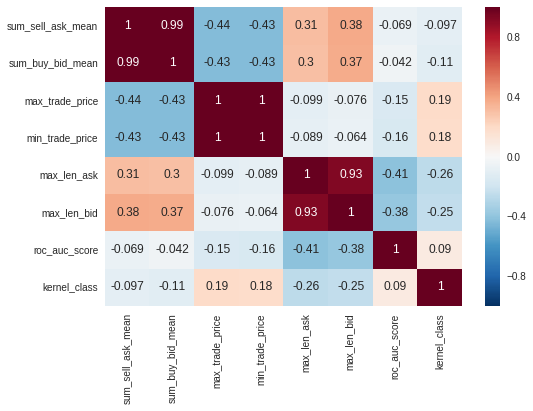

In [7]:
features = ['sum_sell_ask_mean', 'sum_buy_bid_mean', 'max_trade_price', 'min_trade_price',
            'max_len_ask', 'max_len_bid', 'roc_auc_score', 'kernel_class']
sns.heatmap(df_summary[features].corr(), annot=True)

Interesting correlations:

* `mean_bid_len` has correlation -0.8 with `roc_auc_score`
* `mean_ask_len` have correlation about -0.56 with `roc_auc_score`
* `mean_bid_ask_len` have correlation about -0.67 with `roc_auc_score`

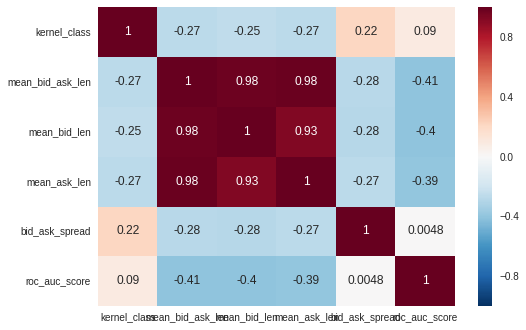

In [8]:
features = ['kernel_class', 'mean_bid_ask_len', 'mean_bid_len', 'mean_ask_len',
            'bid_ask_spread', 'roc_auc_score']
sns.heatmap(df_summary[features].corr(), annot=True)

###### Kernel choice vs `mean_bid_ask_len`

When we look at the table below we can see that for lower values of mean_bid_ask_len it could be that sigmoid kernel is better and for the bigger values rbf kernel should be the right choice.

In [9]:
df_summary[['kernel', 'roc_auc_score', 'mean_bid_ask_len']].sort_values(by='mean_bid_ask_len')

,kernel,roc_auc_score,mean_bid_ask_len
11869,sigmoid,0.567627,399.933333
12417,rbf,0.579650,411.356917
1431,rbf,0.555514,414.739417
12255,sigmoid,0.580376,452.682750
4549,sigmoid,0.576860,454.126167
11946,sigmoid,0.583967,465.986750
10484,sigmoid,0.558058,467.213917
12456,sigmoid,0.563869,478.209250
3035,rbf,0.586108,518.150667
8080,sigmoid,0.590127,538.434417


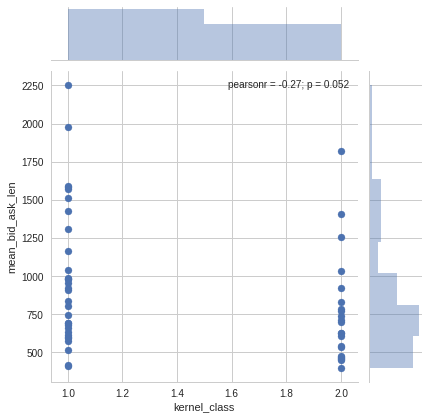

In [10]:
sns.jointplot("kernel_class", "mean_bid_ask_len", data=df_summary)

## Best kernel distrubution


We use violin plots to plot the kernel KDE distributions against `mean_bid_ask_len`.
* white dot represents the median
* thick gray bar in the center represents the interquartile range
* thin gray line represents the 95% confidence interval

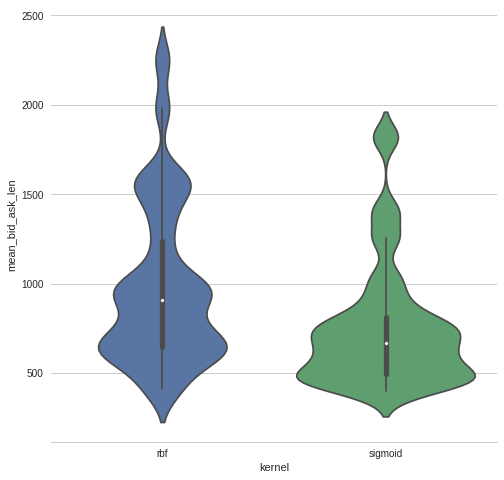

In [11]:
f, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(x='kernel', 
           y='mean_bid_ask_len', data=df_summary, cut=2, bw=0.2)
sns.despine(left=True)

It seems it might be biased, because our data doesn't have normal distribution for `mean_bid_ask_len` metric.

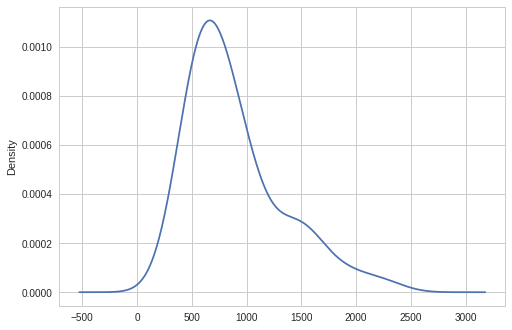

In [12]:
df_summary['mean_bid_ask_len'].plot('kde')

### Against `roc_auc_score`

We use violin plots to plot the kernel KDE distributions against `roc_auc_score`.
* white dot represents the median
* thick gray bar in the center represents the interquartile range
* thin gray line represents the 95% confidence interval

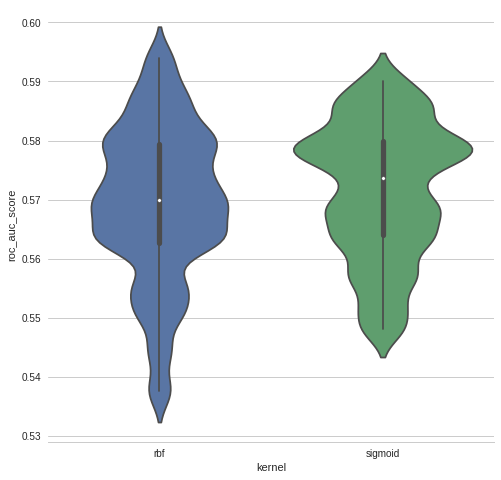

In [13]:
f, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(x='kernel', 
           y='roc_auc_score', data=df_summary, cut=2, bw=0.2)
sns.despine(left=True)

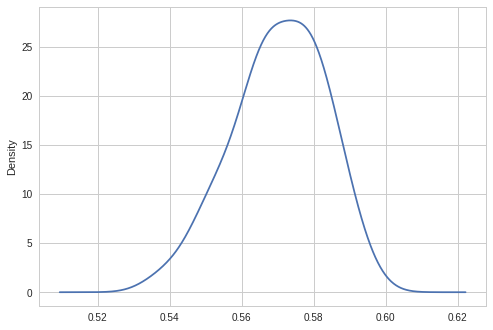

In [14]:
df_summary['roc_auc_score'].plot('kde')

## Learning curves

We plot learning curves using 3-fold cross validation method (it uses consecutive folds) for `mean_bid_ask_len`  grouped by kernels.

In [15]:
df_best_agg = df_res_cv.groupby(['stock', 'kernel'], as_index=False)['roc_auc_score'].idxmax()
df_bests_by_kernels = df_res_cv.loc[df_best_agg]
data_len = []
for i, row in df_bests_by_kernels.iterrows():
    data_len.append(df_summary.loc[row['stock']]['mean_bid_ask_len'])
df_bests_by_kernels['mean_bid_ask_len'] = data_len
df_bests_by_kernels.head()

,c,coef0,gamma,kernel,roc_auc_score,stock,mean_bid_ask_len
146,0.500,0.0,-1.0,linear,0.559372,10166,911.517583
31947,500.000,0.0,100.0,rbf,0.562580,10166,911.517583
93,0.005,5.0,500.0,sigmoid,0.560516,10166,911.517583
10975,0.005,0.0,-1.0,linear,0.551864,10484,467.213917
11007,0.500,0.0,5.0,rbf,0.554403,10484,467.213917


In [16]:
def plot_learning_curve_for_idx(df_best_by_kernels, idx):
    for i in idx.index:
        row = df_bests_by_kernels.loc[i]
        s = row['stock']
        gamma = row['gamma']
        if row['gamma'] == -1:
            gamma = 'auto'
        clf = SVC(kernel=row['kernel'], C=row['c'], gamma=gamma, coef0=row['coef0'])
        lob.plot_learning_curve(clf, X=dfs[s]['queue_imbalance'].reshape(-1, 1), 
                            y=dfs[s]['mid_price_indicator'],
                               title=row['stock'] + ' ' + row['kernel'])
        plt.figure()

#### Linear kernel for stocks with biggest `mean_bid_ask_len`

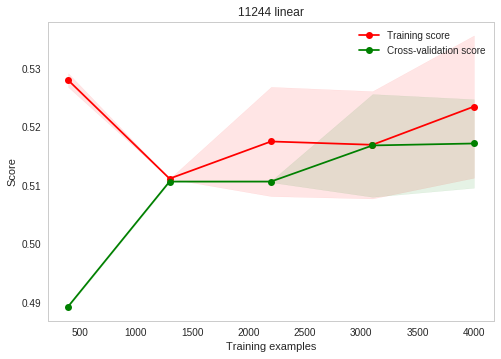

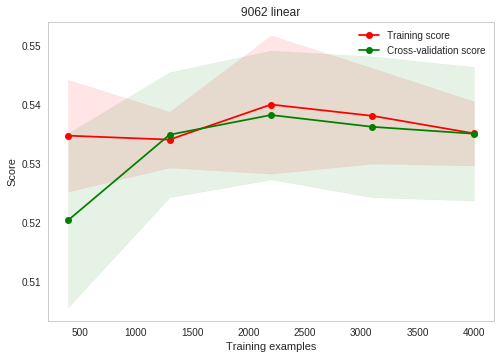

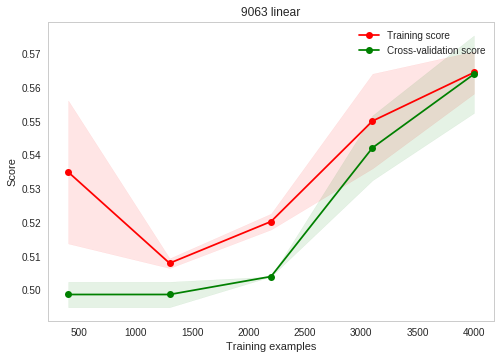

In [17]:
longest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'linear']['mean_bid_ask_len'].nlargest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, longest_idx)

#### RBF kernel for stocks with biggest `mean_bid_ask_len`

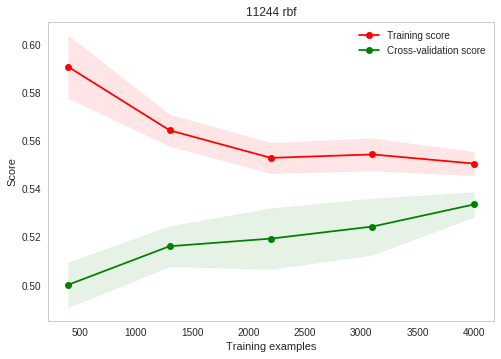

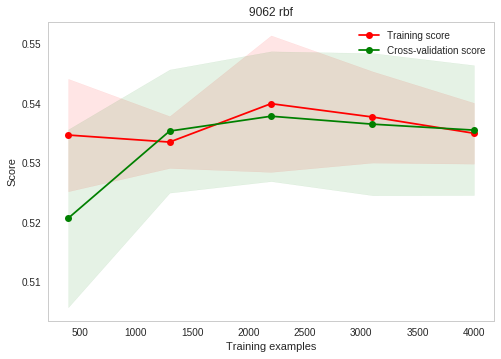

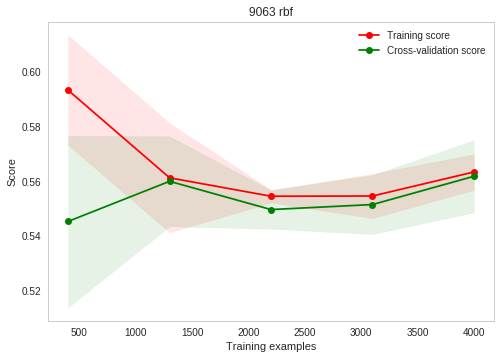

In [18]:
longest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'rbf']['mean_bid_ask_len'].nlargest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, longest_idx)

#### Simogid kernel for stocks with biggest `mean_bid_ask_len`

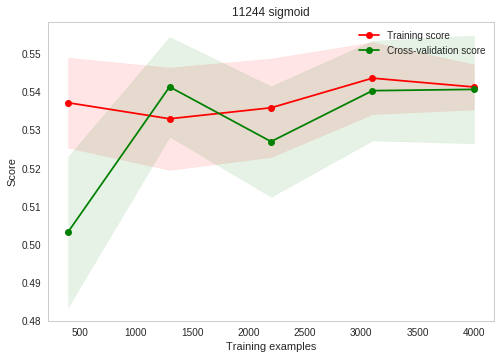

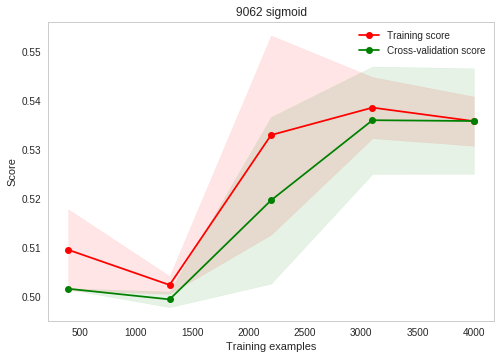

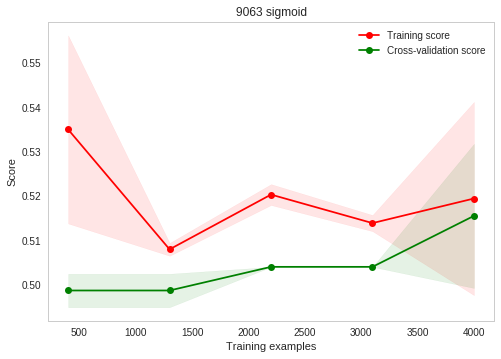

In [19]:
longest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'sigmoid']['mean_bid_ask_len'].nlargest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, longest_idx)

#### Linear kernel for stocks with biggest `mean_bid_ask_len`

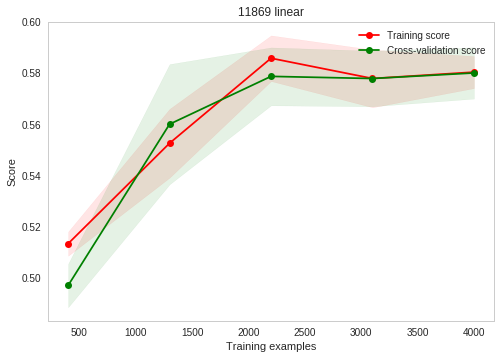

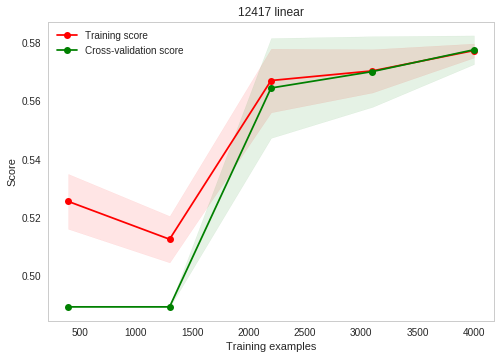

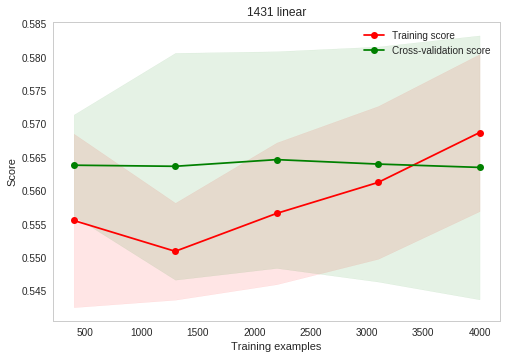

In [20]:
smallest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'linear']['mean_bid_ask_len'].nsmallest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, smallest_idx)

#### RBF kernel for stocks with biggest `mean_bid_ask_len`

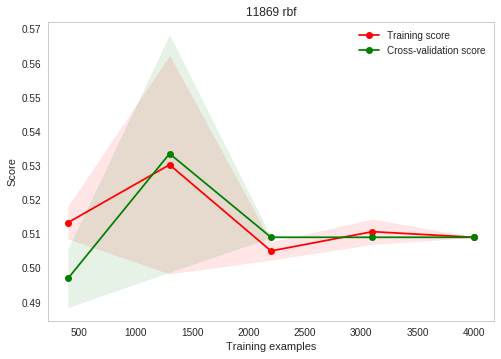

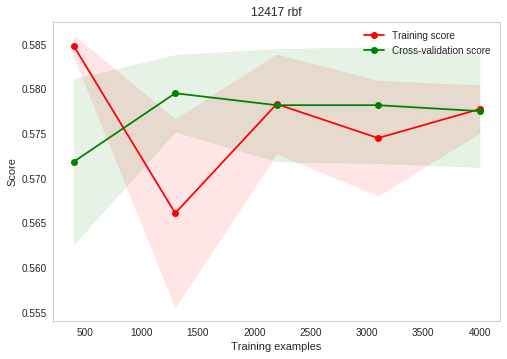

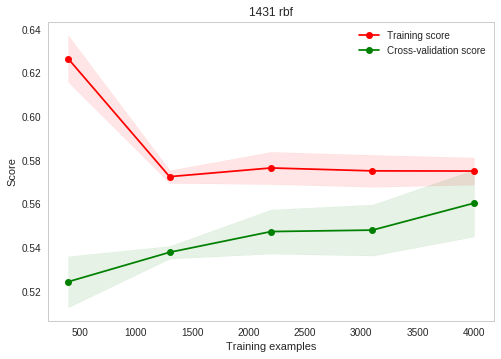

In [21]:
smallest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'rbf']['mean_bid_ask_len'].nsmallest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, smallest_idx)

#### Simoid kernel for stocks with biggest `mean_bid_ask_len`

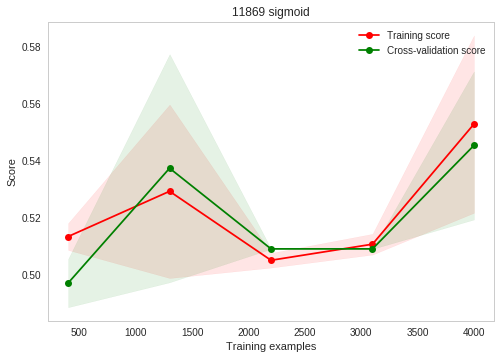

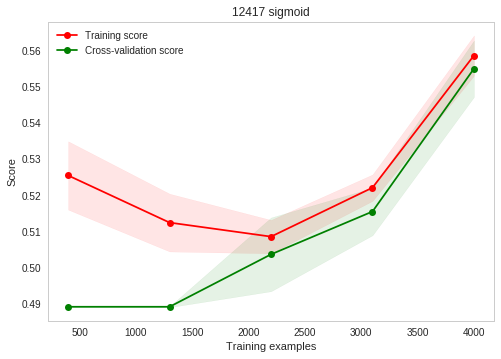

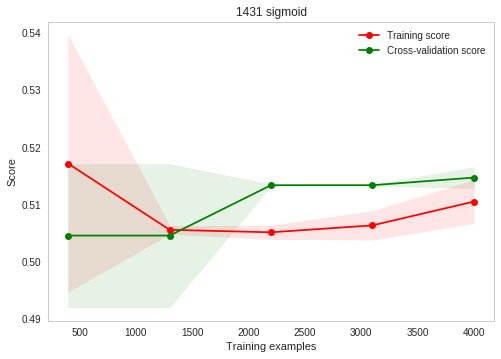

In [22]:
smallest_idx = df_bests_by_kernels[df_bests_by_kernels['kernel'] == 'sigmoid']['mean_bid_ask_len'].nsmallest(3)
plot_learning_curve_for_idx(df_bests_by_kernels, smallest_idx)

## Conclusions

There is a hipothesis that `mean_bid_ask_len` could be the metric which will help decide at least which kernel one should pick. It might be that for values above 1000 it might be that rbf kernel is better. For the other values sigmoid kernel can be better.

For some stocks 10000 data points is not enough - we are overfitting. For some we are underfitting.